# Precomputed Bounding Surface Constitutive Model
# Solution Matrices
---
> Copyright ©2019 Arduino Computational Geomechanics Group and Justin Bonus.  All rights reserved. No use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these materials should contact the author.
---

This notebook presents the process of calculating all possible discrete solutions to a differential equation within a natural boundary, storing them in an accesible format. In effect, it 'solves' the constitutive relationship in its entirety, thereby completely removing the need to ever recalculate solutions for the constitutive model.

This idea will be examined in the context of a specific constitutive model, *Borjas & Amies 1994*, due to its simplicity yet flexibility, but could be applied to varous other models.

It is generally a good idea to restart the kernel and run all cells sequentially to make sure the code runs correctly.

A number of common libraries must be imported to use/edit the entire notebook in the .ipynb format. 
 - ```numpy``` - For basic math and array manipulation
 - ```collections.namedtuple``` - For variable structures
 - ```scikit``` - For some geometry
 - ```matplotlib``` - For data visualization
 - ```mpl_toolkits``` - For 3D plotting
 - ```ffmpeg``` - For animation embedment

For those using the notebook in .html format it is unneccesary to install any packages.

In [1]:
# For basic math, arrays, and structures
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from IPython.display import HTML
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import various functions
%run ~/School/CESG508/'Bounding Surface'/Utilities.ipynb
%run ~/School/CESG508/'Bounding Surface'/Visuals.ipynb
%run ~/School/CESG508/'Bounding Surface'/Animations.ipynb
%run ~/School/CESG508/'Bounding Surface'/Misc.ipynb
%run ~/School/CESG508/'Bounding Surface'/Precomputed.ipynb

<IPython.core.display.Javascript object>


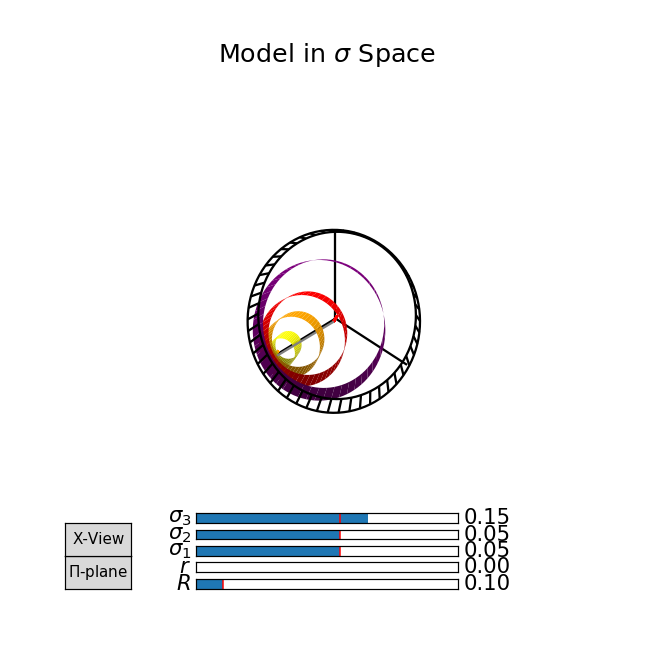

In [4]:
%matplotlib notebook
%matplotlib notebook
borjasInteractive()

---
# Precomputation

As it stands, a differential equation is being solved via Newton-Rhapson iterations for every time step in order to produce a deviatoric stress increment. This method slows as the model becomes increasingly plastic, and oftentimes identical solutions are recomputed.

Modern advances in cloud computation, parallel computation, and general data storage have allowed for completely removing real-time solutions from constitutive models. Instead, accessing precomputed matrices containing all possible solutions replaces the computationally expensive solver method with a series of matrix calls.

Traditional perspectives might suggest that matrices containing all solutions are:
 * Too large to store
 * Too large to compute
 
However, by utilizing the natural boundary of the equations (i.e. the stress bounding surface for Borjas & Amies 1994) and various instances of solution symetry and redundancy, the matrices can be made relatively compact and quick to compute.

A total of **three** precomputed matrices will be assembled:
 * $\kappa$ Matrix
 * $H'$ Matrix
 * $\psi$ Matrix

Matrices will be created in a cartesian representation of the $\Pi$-plane. This is for ease of construction and access. A polar coordinate system is a more compact alternative as it does not include any cells outside of the bounding surface, but is slightly less intuitive to construct and access.

---
## Discrete Resolution

By imposing a grid onto the $\Pi$-plane and solving at every intersection point we are able to create a finite number of solutions for a continous space. Higher resolution grids better characterize the true function but require more HDD/SSD space for storage, as well as taking a longer time to compute. Lower resolution grids have lower accuracy but are leaner in storage and use.

This is fairly abstract, first let's demonstrate the idea of a discrete resolution for precomputation on the most basic constitutive model: Hooke's linear elastic spring.

$$ \sigma = E \epsilon $$

This equation creates a straight line that stretches from $-\infty$ to $\infty$ in both the $\sigma$ and $\epsilon$ axis. For most engineering applications, its unlikely we will reach $\infty$ anything. Imagine we have a material that will fail, as determined by testing, at 20 MPa. We can impose a stress boundary at 20 MPa in tension or compressions and only consider that range. 

Taking it a step further, we can say that we only really need ten or so points within that range to get a good idea of how the model works. Obviously this will create zones inbetween points where the model isn't well defined, but linear interpolation or other methods could fix that.

<IPython.core.display.Javascript object>


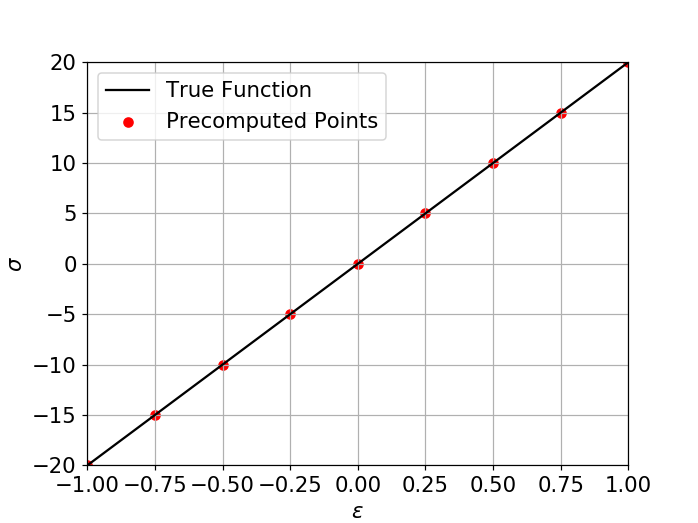

Mapping Matrix:  [-20. -15. -10.  -5.   0.   5.  10.  15.  20.]
Solution Matrix: [-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]


In [5]:
%matplotlib notebook

boundary = 20 # Material boundary on stress before failure, MPa
resolution = 9 # Number of points to precompute

# Stress grid stretching from positive and negative boundary, resolution determines grid density
y = np.linspace(-boundary, boundary, resolution) # Stress grid, MPa
E = 20 # Elastic modulus, MPa
x = y/E # Strain, dimensionless

mapMatrix = y
solutionMatrix = x

fig, axes = plt.subplots(1,1)
axes.plot(x,y, color='black', label='True Function')
axes.scatter(x,y, color='red', label='Precomputed Points')
axes.xaxis.grid(True)
axes.yaxis.grid(True)
axes.set_xlim(x.min(),x.max())
axes.set_ylim(y.min(),y.max())
axes.set_xlabel('$\epsilon$')
axes.set_ylabel('$\sigma$')
plt.legend()
plt.show()
print('Mapping Matrix: ', mapMatrix)
print('Solution Matrix:', solutionMatrix)

We now have a series of points stored in an array that tell us the strain if we tell it the stress (or vice-versa, if we impose the bounding range with strain values instead) with no need to actually use the underlying constitutive equation. In essence, we've solved the model within a range, on a discrete grid of our choice.

An initial reaction may be that this is entirely pointless, as a linear equation is so simple to solve that storing a select few points is a waste of time. This is true, but for more complex nonlinear models such as *Borjas & Amies 1994* it can be fairly time consuming to solve the constitutive equation everytime we want to use it.

In [6]:
def precomputedHookeMatrix(b, r, e):
    # Assemble matrices for Linear Elastic Hooke Spring  
    boundary = b # Material boundary on stress before failure, MPa
    resolution = r # Number of points to precompute
    E = e # Elastic modulus, MPa

    y = np.linspace(-boundary, boundary, resolution) # Stress grid, MPa
    x = y/E # Strain, dimensionless

    mapMatrix = np.ndarray.tolist(y) # Convert to list 
    solutionMatrix = np.ndarray.tolist(x) # Convert to list
    
    return mapMatrix, solutionMatrix

In [7]:
def precomputedHookeRadialMap(stress, mapMatrix, solutionMatrix):
    closestStress = min(mapMatrix, key = lambda x:np.abs(stress - x))    # Find closest stress in mapping matrix
    i = mapMatrix.index(closestStress)    # Determine index of closest stress
    strain = solutionMatrix[i]    # Find corresponding strain
    return strain

In [8]:
def precomputedHookeDriver(mapMatrix, solutionMatrix):
    nPoints = 50 # Number of timesteps
    nCycles = 2 # Harmonic cycles
    omega   = 0.15
    boundary = 10 # Currently 10 MPa, will be dynamic
    
    time   = np.linspace(0, nCycles*2*np.pi/omega, nCycles*nPoints+1)
    stress = boundary*np.sin( omega*time )
    strain = [] # Initialize strain
    for i in range(0,len(time)):
        strain.append(precomputedHookeRadialMap(stress[i], mapMatrix, solutionMatrix)) # Append new value each time step
    return time, stress, strain

Run the interactive precomputed version of Hooke's linear elastic constitutive model.

<IPython.core.display.Javascript object>


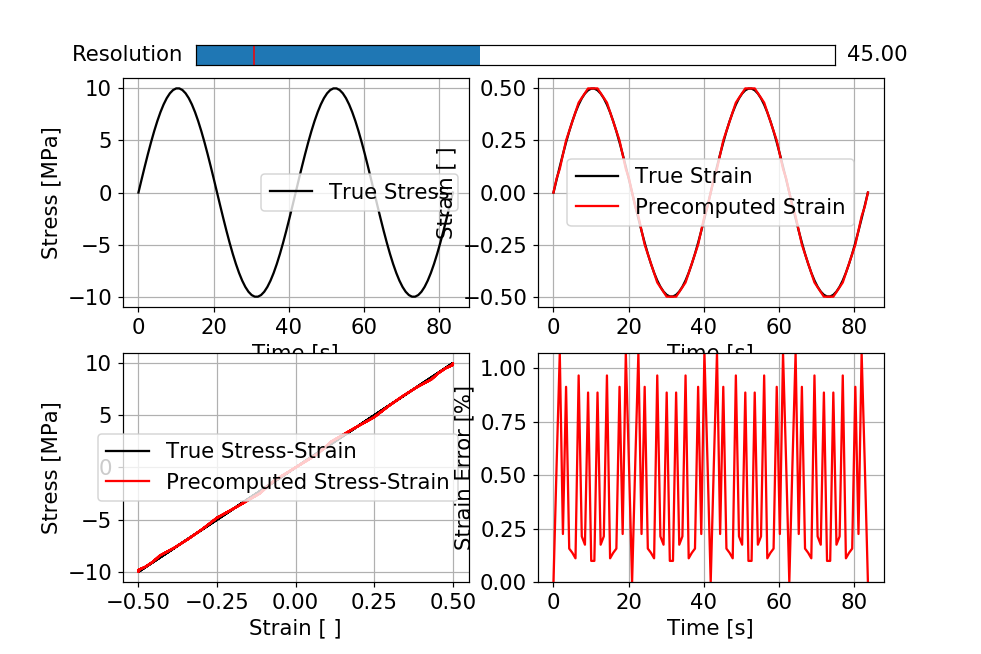

In [9]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
from PIL import Image
import numpy

def update(val):
    # Update parameters
    B = B0
    R = sR.val 
    E = E0    

    # Recalculate data with updated parameters
    mapMatrix, solutionMatrix = precomputedHookeMatrix(B, R, E)
    time, stress, strain = precomputedHookeDriver(mapMatrix, solutionMatrix)
    trueStrain = stress/E
    errStrain = 100*np.abs(trueStrain - strain)/np.abs(max(trueStrain)-min(trueStrain))

    # Update artist objects	
    p2.set_ydata(strain)
    p3.set_xdata(strain)
    p4.set_ydata(errStrain)
    axes[1,1].set_ylim(0,max(errStrain))
    # Draw
    fig.canvas.draw_idle()
    
# -------------------------------------------------------------------------------------------
B0 = 10 # Initial boundary
R0 = 10 # Initial resolution
E0 = 20 # Initial elastic modulus

mapMatrix, solutionMatrix = precomputedHookeMatrix(B0, R0, E0)
time, stress, strain = precomputedHookeDriver(mapMatrix, solutionMatrix)
trueStrain = stress/E0
errStrain = 100*np.abs(trueStrain - strain)/np.abs(max(trueStrain)-min(trueStrain))
# -------------------------------------------------------------------------------------------

fig, axes = plt.subplots(2,2, figsize=(9,6))

t1, = axes[0,0].plot(time,stress, color='black', label='True Stress')
t2, = axes[0,1].plot(time, trueStrain, color='black', label='True Strain')
p2, = axes[0,1].plot(time, strain, color='red', label='Precomputed Strain')
t3, = axes[1,0].plot(trueStrain, stress, color='black', label='True Stress-Strain')
p3, = axes[1,0].plot(strain, stress, color='red', label='Precomputed Stress-Strain')
p4, = axes[1,1].plot(time, errStrain, color='red', label='Precomputed Error')

axes[0,0].set_xlabel('Time [s]')
axes[0,0].set_ylabel('Stress [MPa]')
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].set_xlabel('Time [s]')
axes[0,1].set_ylabel('Strain [ ]')
axes[0,1].legend()
axes[0,1].grid(True)

axes[1,0].set_xlabel('Strain [ ]')
axes[1,0].set_ylabel('Stress [MPa]')
axes[1,0].legend()
axes[1,0].grid(True)

axes[1,1].set_xlabel('Time [s]')
axes[1,1].set_ylabel('Strain Error [%]')
axes[1,1].grid(True)

# Basic axes settings
#axes.margins(x=0)
axcolor = 'white'

# Set up resolution slider
axR = plt.axes([0.2, 0.9, 0.65, 0.03], facecolor=axcolor)
sR = Slider(axR, 'Resolution', 1, 100, valinit=R0, valstep=1)
sR.on_changed(update)

# Draw
plt.show()

## Spaces

* $\Pi$-plane
* $O\Pi$
* $A\Pi$

<IPython.core.display.Javascript object>


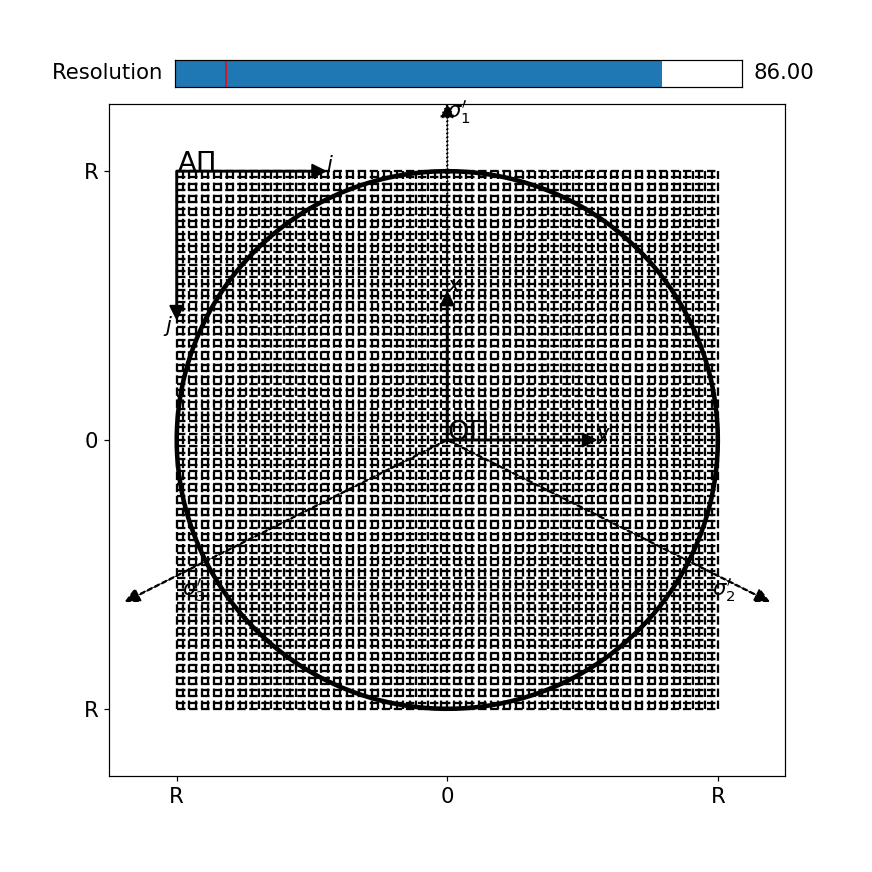

In [10]:
%matplotlib notebook
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

def update(val):
	# Update Resolution from slider
	Res = sRes.val
	# Clear and repopulate axes
	axes.clear()
	draw()	
	
	# Draw new resolution grid
	for r in range(0,int(Res)+1):
		xline = [-R,R]
		yline = [-R + r*2*R/(Res),-R + r*2*R/(Res)]
		axes.plot(xline, yline, color='black', linestyle='--')
		yline = [-R,R]
		xline = [-R + r*2*R/(Res),-R + r*2*R/(Res)]
		axes.plot(xline, yline, color='black', linestyle='--')

	fig.canvas.draw_idle()

def draw():
	# Bounding Surface
	axes.plot(xx,yy, color='black',label='Bounding Surface', linewidth=3)

	# Principle stress axis
	axes.arrow(0,0,0,1.2*R,width=.003*R,head_width=.005,head_length=.005, color='black',linestyle=':')
	axes.arrow(0,0,1.4*np.sqrt(2/3)*R,-np.sqrt(1/3)*R,width=.003*R,head_width=.005,head_length=.005, color='black',linestyle='--')
	axes.arrow(0,0,1.4*-np.sqrt(2/3)*R,-np.sqrt(1/3)*R,width=.003*R,head_width=.005,head_length=.005, color='black',linestyle='--')
	axes.text(0, 1.2*R, '$\sigma_1\'$', color = 'black')
	axes.text(1.2*np.sqrt(2/3)*R, -np.sqrt(1/3)*R, '$\sigma_2\'$', color = 'black')
	axes.text(1.2*-np.sqrt(2/3)*R, -np.sqrt(1/3)*R, '$\sigma_3\'$', color = 'black')

	# Orgin \Pi Axis
	axes.text(0,0,'O$\Pi$',fontsize=18)
	axes.arrow(0,0,R/2,0,width=.005*R,head_width=.05*R,head_length=.05*R, color='black')
	axes.arrow(0,0,0,R/2,width=.005*R,head_width=.05*R,head_length=.05*R, color='black')
	axes.text(0, R/2 + 0.05*R, '$x$', color = 'black')
	axes.text(R/2 + 0.05*R, 0, '$y$', color = 'black')
	
	# Array \Pi Axis
	axes.text(-R,R, 'A$\Pi$', fontsize=18)
	axes.arrow(-R,R,R/2,0,width=.005*R,head_width=.05*R,head_length=.05*R, color='black')
	axes.arrow(-R,R,0,-R/2,width=.005*R,head_width=.05*R,head_length=.05*R, color='black')
	axes.text(-R/2 + 0.05*R, R, '$i$', color = 'black')
	axes.text(-R - 0.05*R, R/2 - 0.1*R, '$j$', color = 'black')

	# Axis settings
	axes.set_xlim(-(5/4)*R,(5/4)*R)
	axes.set_xticks([-R,0,R])
	axes.set_xticklabels(['R','0','R'])
	axes.set_ylim(-(5/4)*R,(5/4)*R)
	axes.set_yticks([-R,0,R])
	axes.set_yticklabels(['R','0','R'])
	axes.grid(False)

	plt.show()


# ---------------------------------------------------------------------

R = 0.1 # Initial bounding surface radius
Res0 = 10 # Initial Resolution

# Set up figure
fig, axes = plt.subplots(1,1, figsize=(8,8))

# Bounding surface coordinates
rr = np.linspace(0,2*np.pi,360)
xx = R*np.sin(rr)
yy = R*np.cos(rr)

# Set up resolution slider
axcolor = 'white'
axRes = plt.axes([0.2, 0.9, 0.65, 0.03], facecolor=axcolor)
sRes = Slider(axRes, 'Resolution', 1, 100, valinit=Res0, valstep=1)
sRes.on_changed(update)

# Draw initial resolution grid
for r in range(0,Res0+1):
	xline = [-R,R]
	yline = [-R + r*2*R/(Res0),-R + r*2*R/(Res0)]
	axes.plot(xline, yline, color='black', linestyle='--')
	yline = [-R,R]
	xline = [-R + r*2*R/(Res0),-R + r*2*R/(Res0)]
	axes.plot(xline, yline, color='black', linestyle='--')

# Draw axes
draw()

plt.show()


---
On a personal computer it is recommended to not exceed a resolution of ~101. Many computers can handle higher resolution matrices, but Jupyter notebook throttles CPU usage (e.g. limits to one core) and can crash when trying to load large matrices (especially the $\psi$ matrix) into the RAM.

In [11]:
# Clean RAM
kappaM, hardeningM, psiM = None, None, None

In [12]:
#============================== MATRIX SETTINGS ==============================
res_x = 101 # Best to remain under 101 unless your system has a lot of RAM
res_y = res_x
minKappa = 1e-5
maxKappa = 1e6
#=============================================================================

In [13]:
#============== STATIC PARAMETERS ==============
E = 20 #Elastic Modulus  MPa
v= 0.49 #Poissons ratio, less than 0.5 to allow compresibility
Su = 0.061 #Yield stress in 1-D tension test MPa

G = E/(2*(1+v)) #Shear modulus
K = E/(3*(1-2*v)) #Bulk modulus
RR = Su*(8/3)**0.5 #R
beta = 0.5 #Midpoint integration
Kmod = 0 #Isotropic Hardening

hh = round(G,4) #kinematic hardening parameter, rounded for cleanliness
mm = 1.0 #kinematic hardening parameter
#===============================================

# Creating the $\kappa$ Matrix

$$\pmb{\hat{\sigma}}' = \pmb{\sigma}' + \kappa(\pmb{\sigma}'-\pmb{\sigma}_{0}') $$

This $\kappa$ value is determined via upholding the following relationship:

$$ \left\lVert \pmb{\hat{\sigma}}' \right\rVert = \left\lVert \pmb{\sigma}' + \kappa(\pmb{\sigma}'-\pmb{\sigma}_{0}') \right\rVert = R $$

This is an expensive equation computationally, involving multiple vector computations for 3D stress scenarios. However, in a 1D scenario only inexpensive scalar operations are required. $\kappa$ can be solved in 1D as follows.
$$ \kappa =   \left\{
\begin{array}{ll}
      |\frac{R - \pmb{\sigma}' }{\pmb{\sigma}'-\pmb{\sigma}_{0}'}| & for \space \pmb{\sigma}' \geq \pmb{\sigma}_{0}'\\
      |\frac{R + \pmb{\sigma}' }{\pmb{\sigma}'-\pmb{\sigma}_{0}'}| & for \space \pmb{\sigma}' < \pmb{\sigma}_{0}'\\
\end{array} 
\right.  $$

For the fully defined range there will be two points of equal value, one on either side of the unloading stress.
$$ \pmb{\sigma}' =   \left\{
\begin{array}{ll}
      \frac{R + \kappa \pmb{\sigma}_{0}'}{\kappa + 1} & for \space \pmb{\sigma}' \geq \pmb{\sigma}_{0}'\\
      -\frac{R - \kappa \pmb{\sigma}_{0}'}{\kappa + 1} & for \space \pmb{\sigma}' < \pmb{\sigma}_{0}'\\
\end{array} 
\right.$$ 

The midpoints for the pairs can be found with the following formula:

$$
\pmb{\sigma}'_{midpoint} = \frac{\kappa \pmb{\sigma}_{0}'}{\kappa + 1}
$$

Knowing the midpoint is useful, as it will allow us to rotate stress values around contours of equal $\kappa$ value. This will be a critical operation for reducing the size of the $\psi$ solution matrices.

But how can we use a 1D formulation for a multi-dimensional stress space?

1. Ensure stresses are converted to normal principal stress form (i.e. 3D) 
2. Consider that the $\Pi$-plane is 2D
3. Evaluate values only on the centerline of the $\Pi$-plane, forcing 1D behavior

With all values of $\kappa$ determined for our centerline we can now fill out the rest of the bounding surface interior with a few tricks. 
1. Since each equipotential contour will cross the centerline twice, by finding matching values on the centerline we will be able to constrain each circle. 
2. We can then compute the midpoint and radius of each individual contour and construct properly located equipotential circles. 
3. These circles can be combined to fully define the bounding surface interior.

**BUGS**

`kappaLayer` will be overhauled to be cleaner soon, relying more heavily on the geometry toolboxes of scikit. A few other issues still need to be fixed as well (e.g. properly weighting cell values when they are overwritten multiple times, centerline shadow, etc.) but it functions decently.

In [14]:
def kappaLayer(res_x, res_y, minKappa, maxKappa, Stress0):
    #===============================================================================================
    # Kappa Matrix layer creator for Borjas & Amies 1994 bounding surface constitutive model
    #===============================================================================================
    # Author: Justin K. Bonus, University of Washington
    # Created: July 21, 2019
    #
    # This function creates a complete matrix of all possible kappa values relative to 
    # the last point of unloading.
    # In construction it is agnostic to the active stress point angular position and bounding 
    # surface but in use both must be known to properly access the matrix.
    #
    # One layer of the kappa matrix is made with this function, meaning it only defines
    # kappa contours for a single unloading point.
    #
    # NOTE: This method is highly dependent on input resolution. High resolution will create a
    # profile that is extremely close to the true function, but at low resolutions it will appear
    # to be fairly discontinuous around the centerline and circles will be rough.
    #
    # Workflow: 
    # 0.) Consider centerline symetry (optional, by default it is not used)
    # 1.) Beginning in cartesian coordinates, create zeros matrix of the desired size
    # 2.) Create a ring to represent the bounds of the deviatoric space, set temporary -1. value
    # 3.) Fully evaluate the kappa values in each cell of the centerline, utilizing 1D equation
    # 4.) For each point, find another point opposite the kappa singularity that are equal/near-equal
    # 5.) Define circle contour radii and midpoints from the matched points
    # 6.) Create the kappa value contours with the ring function
    # 7.) Insert new contours onto main matrix, careful to not overwrite/underwrite (thresholds)
    # 8.) Convert to polar coordinates for compactness
    #===============================================================================================
    #import numpy as np
    from skimage.draw import circle
    from skimage.draw import circle_perimeter
    
    radius = int(np.floor(res_x/2))
    cen_x = int(np.floor(res_x/2))
    cen_y = int(np.floor(res_y/2))
    
    def ring(res_x, res_y, midpoint, radius, kappaSouth, kappaNorth):
        # Use Scikit to create efficient circle coordinates
        from skimage.draw import circle_perimeter
        cen_x = int(np.floor(res_x/2))
        cen_y = int(np.floor(res_y/2))
        rr, cc = circle_perimeter(midpoint, cen_x, radius) # Creates coordinates
        donut = np.zeros((res_y, res_x)) # Create empty matrix
        north = np.array([[-1],[0]]) # North unit vector
        for yy, xx in zip(rr,cc):
            yy = yy - midpoint
            xx = xx - cen_x
            index = np.array([[yy],[xx]])
            angle = np.abs(angleIndex(north, index)) # (0 to pi)
            # Weight kappa value at coordinate by angle to south
            donut[rr, cc] = kappaSouth - (angle/np.pi)*(kappaSouth - kappaNorth)
        return donut
        
    cart = np.zeros((res_y,res_x)) # Holds values as they are sequentially added in each \kappa contour
    over = np.zeros((res_y,res_x)) # Holds number of times a cart cell has been overwritten, used for averaging
    
    # Define area within bounding surface with -1 values, outside with 0 values
    rr, cc = circle(cen_y, cen_x, radius)
    cart[rr,cc] = -1
    
    # Define the bounding surface perimeter with -2 values
    rr, cc = circle_perimeter(cen_y,cen_x, radius)
    cart[rr,cc] = -2
    
    # Apply maxKappa value to unloading point, minKappa value to extents of centerline 
    cart[Stress0[0],Stress0[1]] = maxKappa
    cart[0, cen_x], cart[res_y-1, cen_x] = minKappa, minKappa

    # Solve kappa for each cell on the vertical centerline using 1D equation
    # \kappa = (|\sigma'_hat|-|\sigma'|)/(|\sigma'-\sigma'_0|)
    for j in range(0, res_y):
        if j < cen_y and j > Stress0[0]:
            cart[j,cen_x] = (cen_y + np.abs(cen_y-j))/np.abs((cen_y-j)-(cen_y-Stress0[0]))
        else:
            cart[j,cen_x] = (cen_y - np.abs(cen_y-j))/np.abs((cen_y-j)-(cen_y-Stress0[0]))
    
    #Evaluate points on center-line, below Stress0 y-center
    for ja in range(Stress0[0]+1,res_y):
        hold = [] 

        # Evaluate points on center-line, above Stress0 y-center
        for jb in range(1,Stress0[0]):
            # Contain kappa differentials in a list, we want the smallest one 
            # This will allow us to define to points of equipotential
            hold.append(np.abs(cart[jb,cen_x] - cart[ja,cen_x]))  
        if len(hold) != 0:
            jb = hold.index(min(hold)) #jb the best matches ja index
            midpoint = int(np.round((ja+jb)/2)) #Finds index of kappa contour midpoint 
            rad = int(np.abs(midpoint-ja)) #Determines radius of contour
            kappaSouth = cart[ja,cen_x]
            kappaNorth = cart[jb,cen_x]
        else:
            # When at bounding surface?
            midpoint = int(np.round((ja)/2))
            rad = int(np.abs(midpoint-ja)) 
            kappaSouth = cart[ja,cen_x]
            kappaNorth = cart[ja,cen_x]
        
        
        
        donut = ring(res_x, res_y, midpoint, rad, kappaSouth, kappaNorth)
        
        #Insert all kappa contours into main array 
        for x in range(0,res_x):
            #Prevent overwriting of vertical kappa_line
            if x == Stress0[1]:
                continue
            for y in range(0,res_y):
                if donut[y,x] == 0:
                    # Skip zero values   
                    continue
                if cart[y,x] == -1:
                    # Cell is 'empty', write \kappa value to it
                    cart[y,x] = donut[y,x]
                elif cart[y,x] > 0:
                    # Weighted overwriting
                    factor = over[y,x] + 2
                    cart[y,x] = (donut[y,x]*1)/factor + (cart[y,x]*(factor-1))/factor
                    over[y,x] = over[y,x]+1
                    
    #============= POST-PROCESS ============= 
    # Reapply bounding surface and \kappa singularity
    #rr, cc = circle_perimeter(cen_y,cen_x, radius)
    cart[rr,cc] = minKappa
    cart[Stress0[0],Stress0[1]] = maxKappa
    # Horizontal linear interpolation for empty cells
    fill = True
    if fill:
        xp = np.asarray(np.nonzero(cart.ravel() > 0))
        fp = cart[np.nonzero(cart > 0)]
        fp = np.asarray(fp).reshape(1,fp.shape[0])
        x  = np.nonzero(cart.ravel() == -1)
        cart[np.nonzero(cart == -1)] = np.interp(x, xp[0,:], fp[0,:])
      
    return cart

By calling `kappaLayer()` sequentially (or in parallel) as we vary the position of the unloading stress from the center of the $\Pi$-plane to the top edge of the bounding surface, we can create all the layers need to fully define the $\kappa$ matrix. A new function, `kappaMatrix()` will perform this action and output the assembled matrix.

In [15]:
def kappaMatrix(res_x, res_y, minKappa, maxKappa):
    #===============================================================================================
    # Kappa Matrix creator for Borjas & Amies 1994 bounding surface constitutive model
    #===============================================================================================
    # Author: Justin K. Bonus, University of Washington
    # Created: July 21, 2019
    #
    # -----INPUT
    # res_x = X indice resolution (odd #)
    # res_y = Y indice resolution (odd #)
    # minKappa = Minimum \kappa value to apply at bounding surface
    # maxKappa = Maximum \kappa value to apply at singularity
    # -----OUTPUT
    # kappa_matrix: Populated 3D matrix for the desired input settings
    #===============================================================================================
    import numpy as np
    from IPython.display import clear_output
    #Center of space
    cen_x = int(np.floor(res_x/2))
    cen_y = int(np.floor(res_y/2))
    
    kappa_matrix = np.empty((res_y, res_x, cen_y+1)) # Initialize first layer dimensions
    
    # Iteratively create and append \kappa layers to form \kappa matrix
    for layer in range(0,int(np.floor(res_y/2))+1):
        # Varies unloading point on north centerline
        Stress0 = np.array([ cen_y - layer, cen_x ]) 
        cart = kappaLayer(res_x, res_y, minKappa, maxKappa, Stress0) # Retrieves associated \kappa layer
        kappa_matrix[:,:,layer] = cart
        clear_output(wait=True)
        print('Layer:', layer, 'of ', int(res_y/2))                
    print('Kappa Matrix Shape:',kappa_matrix.shape)

    return kappa_matrix

Create the $\kappa$ matrix, save it to directory, and remove it from RAM.

In [16]:
#===============================================================================================
kappaM = kappaMatrix(res_x, res_y, minKappa, maxKappa)
#===============================================================================================
# Write array to *.txt file on disk (HDD, SSD)
fn = 'kappaMatrix_' + str(res_x) + '_' + str(res_y) + '.txt'
with open(fn, 'w') as outfile:
    # Text header for readibility
    outfile.write('# Array shape: {0}\n'.format(kappaM.shape))
    # Iterates through a ndimensional array producing slices along
    # the last axis. This is equivalent to data[i,:,:]
    for data_slice in kappaM:
        # Left-justified columns 7 characters in width, 8 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.8f')

        # Layer breaks using '#', won't be read by loadtxt()
        outfile.write('# New slice\n')

# Remove array from RAM
kappaM = None 
print('kappaMatrix.txt saved to disk and removed from RAM.')
#===============================================================================================

Layer: 50 of  50
Kappa Matrix Shape: (101, 101, 51)
kappaMatrix.txt saved to disk and removed from RAM.


Load $\kappa$ matrix into RAM.

In [17]:
#===============================================================================================
# Read the array from disk
fn = 'kappaMatrix_' + str(res_x) + '_' + str(res_y) + '.txt'
kappaM = np.loadtxt(fn).reshape((res_y,res_x,int(np.floor(res_y/2))+1)) # Returns 3D array
print('Loaded array kappaM into RAM, shape:', kappaM.shape)
#===============================================================================================

Loaded array kappaM into RAM, shape: (101, 101, 51)


Visualize a layer of the matrix in 2D and 3D.

<IPython.core.display.Javascript object>


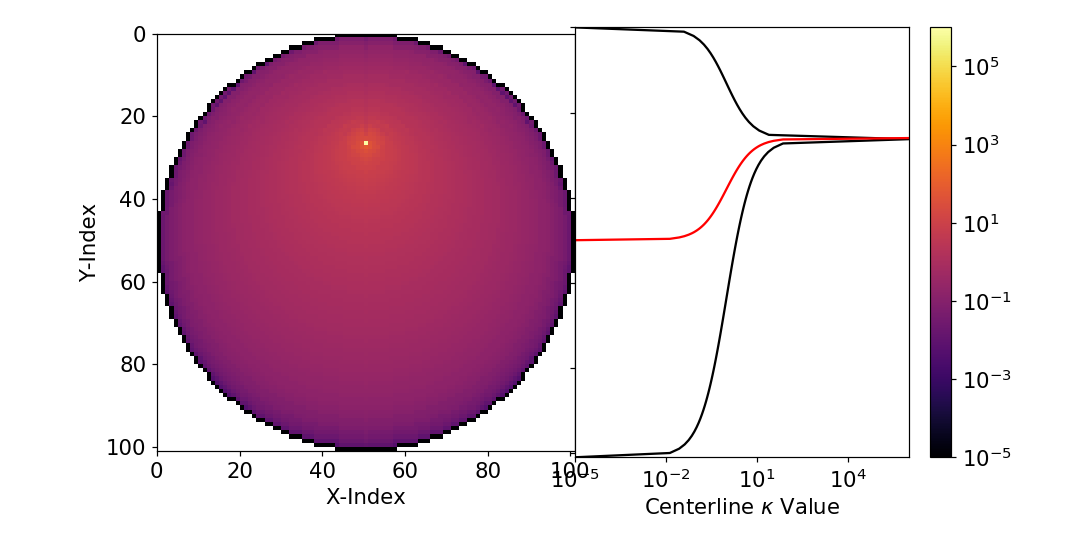

In [18]:
kappaLayer_plot()

<IPython.core.display.Javascript object>


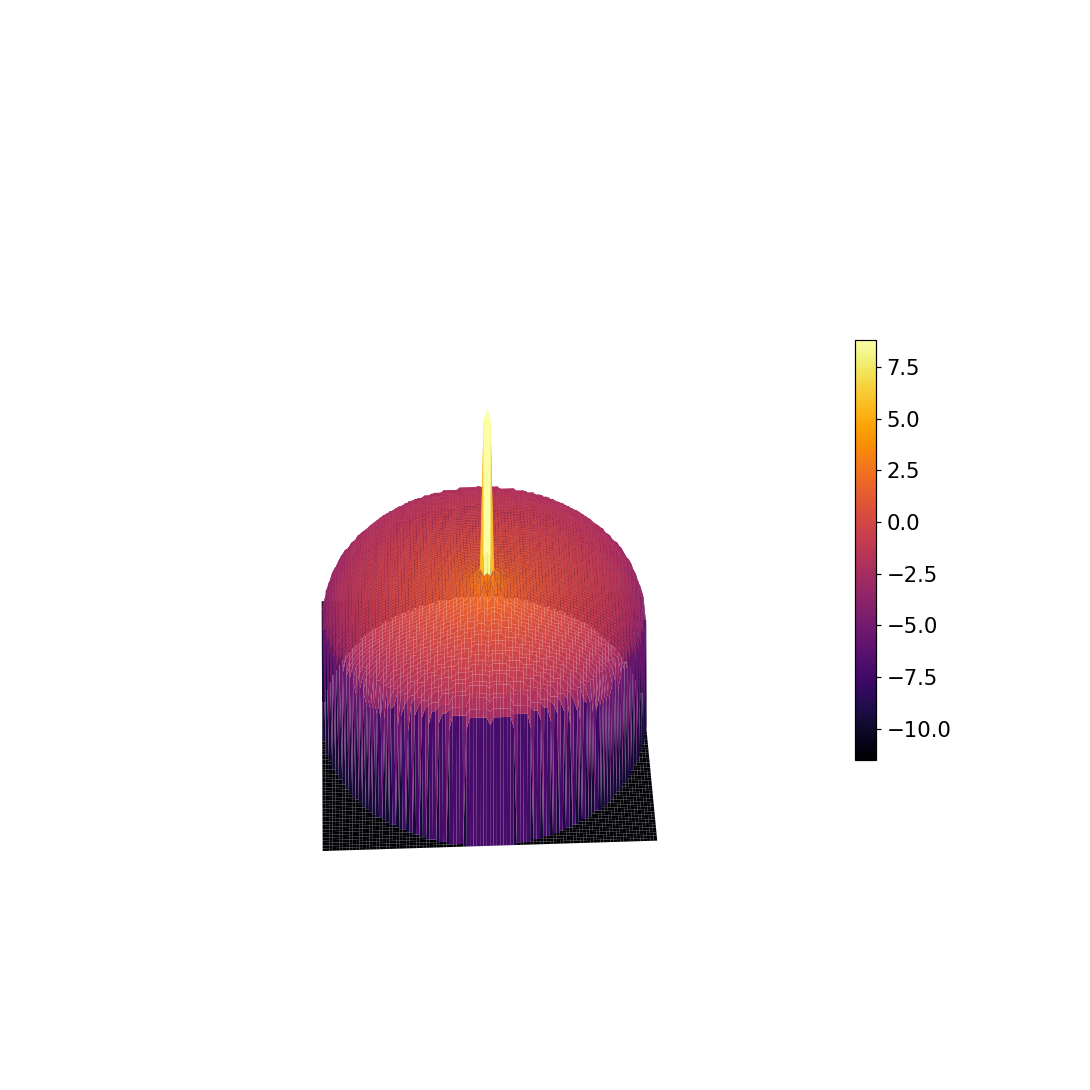

In [19]:
kappaLayer_surf()

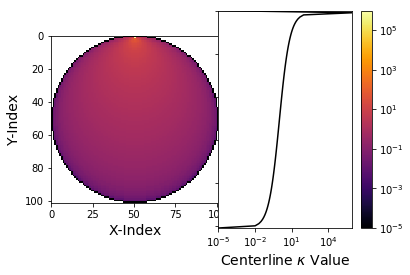

In [20]:
import matplotlib
kappaMatrix_animation(kappaM)

---
# Creating the H' Matrix

A variety of hardening functions are available to choose from. Here we will explore the following exponential function:

$$H' = h\kappa^m $$

Parameters $h$ and $m$ are specified by the operator to tune the model's behavior to observed material behavior. As we have already assembled a $\kappa$ matrix to describe all possible $\kappa$s for stress states within the bounding surface, we can now assemble $H'$ matrices to describe all possible hardening modulis for stress states within the bounding surface.

$$H'_{abijk} = h_{a}\kappa_{ijk}^{m_b} $$

The new $H'$ matrix will be be identical in shape to the $\kappa$ matrix, with an added two dimensions to account for the two new parameters, $h$ and $m$. All values within the matrix are scalar, and due to our choice of hardening functions, equivalue circular contours present in the $\kappa$ matrix are maintained (although values are different). For example, if you want to analyze two different values of $h$ and three different values of $m$ you will have a $H'$ matrix that is six times larger than the $\kappa$ matrix.

In general, the $H'$ matrix is quick to compute, but can be large depending on the initial $\kappa$ matrix resolution and hardening parameter variation. In applications where you are only concerned with a few $h$ and $m$ values, it may be worth it to use $H'$ matrices instead of te $\kappa$ matrix at the cost of HDD/SSD/RAM space. When hundreds of different hardening values are being used (e.g. a large scale FEA simulation) it is preferable to use just the base $\kappa$ matrix and convert $\kappa$ values into $H'$ values while running your program, a fairly insignificant computation.

In [21]:
def hardeningMatrix(h, m, kappaMatrix):
    #=====================================================================================
    # Hardening Matrix creator for Borjas & Amies 1994 bounding surface constitutive model
    #=====================================================================================
    # Author: Justin K. Bonus, University of Washington
    # Created: July 28, 2019
    #
    # Requires access to a previously computed \kappa matrix.
    # Choice of hardening function significantly effects the final matrix, in both values
    # and dimensionality.
    #=====================================================================================
    
    # Exponential hardening function
    # H' = h\kappa^m
    hardeningMatrix = h*kappaMatrix**m
    
    return hardeningMatrix

In [22]:
#============================================
hardeningM = hardeningMatrix(hh, mm, kappaM)
#============================================

# Write array to disk
fn = 'hardeningMatrix_' + str(res_x) + '_' + str(res_y) + '_' + str(hh) + '_'+ str(mm) + '.txt'
with open(fn, 'w') as outfile:
    # Text header for readibility
    outfile.write('# Array shape: {0}\n'.format(hardeningM.shape))

    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in hardeningM:
        # Left-justified columns 7 characters in width, 8 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.8f')

        # Layer breaks using '#', won't be read by loadtxt()
        outfile.write('# New slice\n')

# Remove array from RAM
hardeningM = None 

print(fn + ' saved to disk and removed from RAM.')

hardeningMatrix_101_101_6.7114_1.0.txt saved to disk and removed from RAM.


In [23]:
# Read the array from disk
fn = 'hardeningMatrix_' + str(res_x) + '_' + str(res_y) + '_' + str(hh) + '_'+ str(mm) + '.txt'
hardeningM = np.loadtxt(fn).reshape((res_y,res_x,int(np.floor(res_y/2))+1)) # Returns 3D array

print('Loaded array '+ fn + ' into RAM, shape:', hardeningM.shape)

Loaded array hardeningMatrix_101_101_6.7114_1.0.txt into RAM, shape: (101, 101, 51)


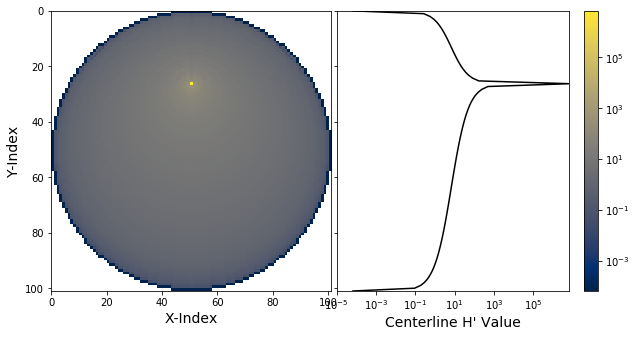

In [24]:
hardeningLayer_plot()

---
# Creating the $\psi$ Matrix

$$\psi + 3\mu\psi (\frac{1-\beta}{H'_{n}} + \frac{\beta}{H'_{n+1}}) = 2\mu$$

$$\pmb{\sigma}_{n+1} = \pmb{\sigma}_n + K tr(\Delta \pmb{\epsilon})\pmb{1} + \psi \Delta \pmb{\epsilon}' $$

Essentially, for each $\kappa_n$ and $\kappa_{n+1}$ there is a corresponding $H'_n$ and $H'_{n+1}$. For steps between $H'$ values there is then a single scalar $\psi$ related to them. In the $H'$ matrix we created a finite number of $H'$ contours, thereby a finite number of $\psi$'s can be computed.

Conventionally, in strain driven scenarios, $\psi$ is found by solving the above two equations simultaneously for both $\kappa_{n+1}$ and $\psi$. This is done through Newton iteration (Borja 1991a) with the initial iterate estimates of: $\psi^0 = 2\mu$ and $\kappa_{n+1}^0 = \kappa_{n}$.

$$\psi = \frac{2\mu}{1+3\mu(\frac{1-\beta}{H'_{n}} + \frac{\beta}{H'_{n+1}})} $$

As plasticity rises, the number of iterations required to converge increases. For simulations where the material is being put under large strains this can lead to very slow solutions.

The full matrix can be described as follows:

$$\psi_{abijkx} = \frac{2\mu_{x}}{1+3\mu_{x}(\frac{1-\beta}{H'_{n_{a_{1}b_{1}i_{1}j_{1}k_{1}}}} + \frac{\beta}{H'_{n+1_{a_{2}b_{2}i_{2}j_{2}k_{2}}}})} $$

This formulation ignores instances of redundancy and creates extremely large matrices. A few methods to compact the matrix are as follow:
 * Implement previously discussed rotational methods within the $\kappa$ and $H'$ matrices
 * Confine $H'_n$ to the centerline containing $\pmb{\sigma}_0$, as all $H'$ contours intersect it ($\frac{1}{360}$ reduction)
 * Consider centerline symetry (50% size reduction)
 * Use only one of two unique intersection points on the centerline for $H'_n$ (~50% size reduction)
 * Construct via polar-coordinates ($\frac{1-2\pi r^2}{1}$ size reduction)
 
For any given layer of the $\psi$ matrix, all of the possible $\psi$ values for a pairing of $\pmb{\sigma}_0$ and $H'_{n}$ are presented. Determining which $\psi$ to use can be done by trying all of them in the following equation:

$$ Tolerance \geq \frac{2G}{1 + 3G(\frac{1-\beta}{H'_n} + \frac{\beta}{H'_{n+1}})} - \psi$$

If the output is less than an operator defined tolerance (e.g. $10^{-2}$) than the corresponding $\psi$ is probably an acceptable solution, but it depends on how much accuracy matters to the operator (higher tolerance increases error). 

However, searching the entire layer is inefficient. Remember that the stress increment, $\Delta\pmb{\sigma}'$, and strain increment, $\Delta\pmb{\epsilon}'$, are always pointing in the same direction. Therefore one must only search for $\psi$ values on a line in the same direction as the strain increment. This reduces search times massively as the matrix resolution increases.

In [21]:
def psiMatrix(hardeningMatrix):
    #=====================================================================================
    # \psi Matrix creator for Borjas & Amies 1994 bounding surface constitutive model
    #=====================================================================================
    # Author: Justin K. Bonus, University of Washington
    # Created: August 05, 2019
    #
    # Requires access to a previously computed H' matrix.
    #=====================================================================================
    from IPython.display import clear_output    

    # First we must initialize the psiMatrix's full shape so we can overwrite
    # values as we solve for psi at each index.
    # Not doing so (i.e. appending layers iteratively) will cause issues with RAM
    depth = hardeningMatrix.shape[1]*(hardeningMatrix.shape[2]+1)
    print('Z depth of', depth, ',', hardeningMatrix.shape[2],' subgroups, with', depth/hardeningMatrix.shape[2], ' layers per subgroup.')
    res_x = hardeningMatrix.shape[0]
    cen_x = int(res_x/2)
    
    psiMatrix = np.zeros((hardeningMatrix.shape[0],hardeningMatrix.shape[1],depth))   
    
    # Vary Stress0 position
    iter = 0
    for k in range(0,hardeningMatrix.shape[2]):
        clear_output(wait=True)
        print('Subgroup:', k)   
        
        # Vary CurStress position along centerline, starting from top
        for j in range(0, hardeningMatrix.shape[1]):                          
            Hn = hardeningMatrix[j,cen_x,k]
            #if Hn == 0:
            #    continue
            
            # Vary NextStress position throughout layer
            for i1 in range(0,hardeningMatrix.shape[0]):
                for j1 in range(0,hardeningMatrix.shape[1]):
                    # Solve \psi at \sigma'_{n+1} relative to \sigma'_{n} and Stress0
                    Hn1 = hardeningMatrix[j1,i1,k]
                    psiMatrix[j1,i1,iter] = (2*G)/(1 + 3*G*((1-beta)/Hn + (beta)/Hn1))
            iter = iter+1
    return psiMatrix

Create the $\psi$ matrix, write it to the disk, and remove it from the RAM.

In [22]:
#============================
psiM = psiMatrix(hardeningM)
#============================

# Write array to disk
fn = 'psiMatrix_' + str(res_x) + '_' + str(res_y) + '_' + str(hh) + '_' + str(mm) + '.txt'
with open(fn, 'w') as outfile:
    # Text header for readibility
    outfile.write('# Array shape: {0}\n'.format(psiM.shape))

    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in psiM:

        # Left-justified columns 7 characters in width, 8 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-2.4f')

        # Layer breaks using '#', won't be read by loadtxt()
        outfile.write('# \n')

# Remove array from RAM
psiM = None 

print( fn + ' saved to disk and removed from RAM.')

Subgroup: 50
psiMatrix_101_101_6.7114_1.0.txt saved to disk and removed from RAM.


In [23]:
# Read the array from disk
cen_y = int(np.floor(res_y/2))
fn = 'psiMatrix_' + str(res_x) + '_' + str(res_y) + '_' + str(hh) + '_' + str(mm) + '.txt'
#depth = res_y*(cen_y)
depth = res_y*(cen_y+2)
psiM = np.loadtxt(fn).reshape((res_y,res_x,depth)) # Returns 3D array

print('Loaded array psiM into RAM, shape:', psiM.shape)
# ERRROR: It really doesnt make sense to just rotate south, this will always increase elastic behavior as we 
# apporach the bounding surface unless search -ine stop-limit is increased

Loaded array psiM into RAM, shape: (101, 101, 5252)


layer: 2551 of 5252


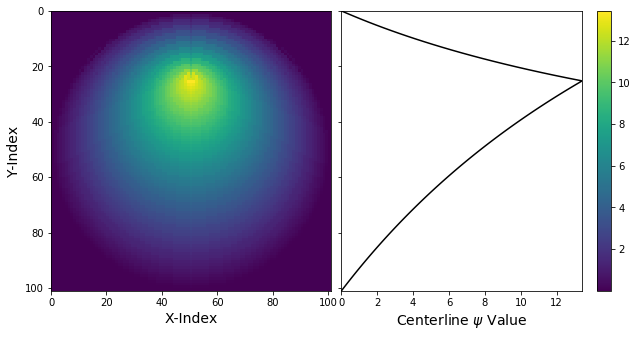

In [24]:
psiLayer_plot()

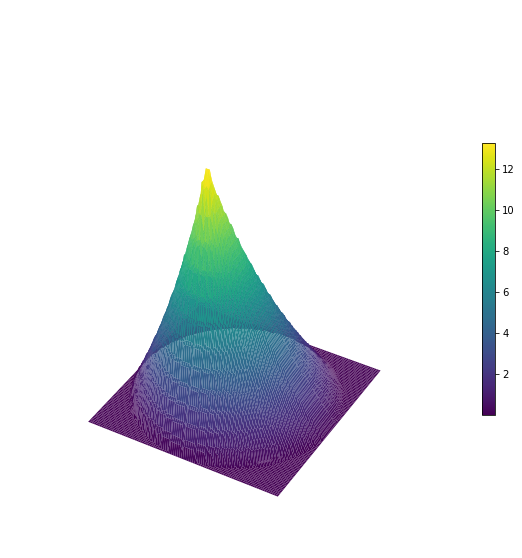

In [25]:
psiLayer_surf()